In [42]:
import pandas as pd
from pathlib import Path
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import rich

from touch_rugby_analyzer.constants import ASSETS_ROOT, ROOT, DATA_ROOT

In [45]:
output_data_root = DATA_ROOT / "output"
output_data_root.mkdir(parents=True, exist_ok=True)


def time_to_n_seconds(time_obj):
    return 3600 * time_obj.hour + 60 * time_obj.minute + time_obj.second


def load_data(data_path, local_team_name, other_team_name):
    data_df = pd.read_csv(data_path)
    data_df = data_df.dropna(axis=0, how="all", subset="Time")
    # data_df.Time = pd.to_datetime(data_df.Time).dt.time
    data_df.Time = pd.to_datetime(data_df.Time)
    game_start_events = data_df[data_df["Name"] == "Game Start"]
    game_end_events = data_df[data_df["Name"] == "Game End"]

    assert len(game_start_events) == len(game_end_events) == 2

    half_time_start_time = game_end_events.Time.to_list()[0]
    half_time_end_time = game_start_events.Time.to_list()[1]
    half_time_end_index = game_start_events.index.to_list()[1]

    new_game_end_time = half_time_start_time + pd.Timedelta(minutes=2)
    delta = new_game_end_time - half_time_end_time

    halftime_passed = False
    ids = []
    for i, row in data_df.iterrows():
        if i == half_time_end_index:
            halftime_passed = True
        if halftime_passed:
            ids.append(i)
    data_df.Time[ids] += delta

    data_df["Against France"].fillna(False, inplace=True)
    data_df["To Review"].fillna(False, inplace=True)

    data_df["Team"] = data_df.apply(
        lambda row: (
            local_team_name
            if (
                (row["Against France"] and row["Type"] in ["Penalty", "Turnover"])
                or (
                    not row["Against France"]
                    and row["Type"] not in ["Penalty", "Turnover"]
                )
            )
            else other_team_name
        ),
        axis=1,
    )
    data_df["TeamOld"] = data_df["Against France"].apply(
        lambda x: other_team_name if x else local_team_name
    )

    def add_team_after(data_df: pd.DataFrame):
        ball_owners = []
        for i, row in data_df.iterrows():
            against_local = row["Against France"]
            if i == 0:
                new_expected_ball_owner = (
                    other_team_name if against_local else local_team_name
                )
            else:
                if row["Type"] == "Try":
                    if not (
                        (against_local and ball_owners[-1] == other_team_name)
                        or (not against_local and ball_owners[-1] == local_team_name)
                    ):
                        rich.print(data_df)
                        rich.print(row)
                        raise Exception("wtf")
                    new_expected_ball_owner = (
                        local_team_name if against_local else other_team_name
                    )
                elif row["Type"] in ["Penalty", "Turnover"] and (
                    (against_local and ball_owners[-1] == local_team_name)
                    or (not against_local and ball_owners[-1] == other_team_name)
                ):
                    new_expected_ball_owner = (
                        other_team_name if against_local else local_team_name
                    )
                elif row["Type"] in ["Game Event"]:
                    new_expected_ball_owner = (
                        other_team_name if against_local else local_team_name
                    )
                else:
                    new_expected_ball_owner = ball_owners[-1]
            ball_owners.append(new_expected_ball_owner)
        data_df["ball_owner"] = ball_owners

    add_team_after(data_df)
    return data_df


def make_fig_1(data_df, local_team_name, other_team_name):
    events = ["Try", "Turnover", "Penalty"]
    fig = make_subplots(len(events), 1, subplot_titles=events, shared_xaxes=True)

    for i, event_name in enumerate(events):
        event_data = []
        event_local, event_other = 0, 0
        for j, row in data_df[data_df["Type"] == event_name].iterrows():
            if row["Against France"]:
                event_other += 1
            else:
                event_local += 1
            event_data.append(
                [
                    row["Time"],
                    event_local,
                    event_other,
                    row["Youtube Link"],
                ]
            )
        event_df = pd.DataFrame(
            event_data,
            columns=[
                "Time",
                f"{event_name} {local_team_name}",
                f"{event_name} {other_team_name}",
                "Link",
            ],
        )

        fig.add_trace(
            go.Scatter(
                x=event_df["Time"],
                y=event_df[f"{event_name} {local_team_name}"],
                name=local_team_name,
                mode="markers+lines+text",
                marker_color="green",
                legendgroup=local_team_name,
                showlegend=i == 0,
                text=[
                    f"<a href='{row['Link']}'>link</a>"
                    for i, row in event_df.iterrows()
                ],
                textposition="bottom center",
            ),
            i + 1,
            1,
        )
        fig.add_trace(
            go.Scatter(
                x=event_df["Time"],
                y=event_df[f"{event_name} {other_team_name}"],
                name=other_team_name,
                mode="markers+lines",
                marker_color="red",
                legendgroup=other_team_name,
                showlegend=i == 0,
            ),
            i + 1,
            1,
        )

    fig.update_layout(
        hovermode="x unified",
        title=f"Statistics for {local_team_name} vs {other_team_name}",
    )
    fig.write_html(output_data_root / "events.html")
    fig.show()
    return fig


def make_game_fig(data_df, local_team_name, other_team_name):
    fig = go.Figure()
    score_data = []
    against_local, prev_time = None, None

    for n, colour in [(local_team_name, "green"), (other_team_name, "red")]:
        points_x, points_y = [], []
        for i, row in data_df.iterrows():
            if row["ball_owner"] == n:
                points_x.append(row["Time"])
                points_y.append(n)
            else:
                if i > 0 and data_df.iloc[i - 1]["ball_owner"] == n:
                    points_x.append(row["Time"])
                    points_y.append(n)
                    points_x.append(None)
                    points_y.append(None)
                else:
                    continue
        fig.add_trace(
            go.Scatter(
                x=points_x,
                y=points_y,
                mode="lines",
                hoverinfo=None,
                marker_color=colour,
                name=n,
            )
        )

    annotations = []
    for i, row in data_df.iterrows():
        # rich.print(f"{row['Type']}-{row['Name']} (Against Local={row['Against France']})")

        if row["Type"] == "Penalty":
            color = "red"
        elif row["Type"] == "Turnover":
            color = "orange"
        elif row["Type"] == "Game Event":
            color = "black"
        else:
            color = "green"
        hovertext = f"{row['Type']}-{row['Name']}"
        fig.add_trace(
            go.Scatter(
                x=[row["Time"]],
                y=[row["Team"]],
                mode="markers",
                # name=hovertext,
                hovertext=hovertext,
                marker_color=color,
                showlegend=False,
            )
        )
        annotations.append(
            dict(
                x=row["Time"],
                y=row["Team"],
                text=f"<a href='{row['Youtube Link']}'>link</a>",
                showarrow=False,
                yshift=10,
            )
        )

    fig.update_layout(annotations=annotations)
    # fig.update_layout(hovermode="x unified", annotations)
    # fig.write_html(output_data_root / "events_v2.html")
    fig.show()
    return fig


def get_stats_df(data_df, local_team_name, other_team_name):
    _data_df = data_df[
        [
            "Type",
            "Name",
            "Team",
        ]
    ][data_df.Type.isin(["Penalty", "Turnover"])]
    output = _data_df.groupby(["Type", "Team", "Name"]).size()
    output.to_csv(output_data_root / "stats.csv", index=True)

    penalty_types = list(_data_df[_data_df["Type"] == "Penalty"]["Name"].unique())
    turnover_types = list(_data_df[_data_df["Type"] == "Turnover"]["Name"].unique())
    column_names = penalty_types + turnover_types

    new_stats_df = pd.DataFrame(
        np.zeros((2, len(column_names)), dtype=int),
        index=[local_team_name, other_team_name],
        columns=column_names,
    )
    for i, row in _data_df.iterrows():
        new_stats_df.loc[row["Team"], row["Name"]] += 1

    # new_stats_df["Average Possession Time"] = [np.mean(local_possesion_ts).round(3), np.mean(other_possesion_ts).round(3)]
    # rich.print(f"{np.mean(local_possesion_ts):.3f}s ({len(local_possesion_ts)} possessions)")
    # rich.print(f"{np.mean(other_possesion_ts):.3f}s ({len(other_possesion_ts)} possessions)")
    # output
    new_stats_df.to_csv(output_data_root / "stats_v2.csv", index=True)
    return new_stats_df

C:\Users\robin\AppData\Local\Temp\ipykernel_5076\3661553388.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\robin\AppData\Local\Temp\ipykernel_5076\3661553388.py:32: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

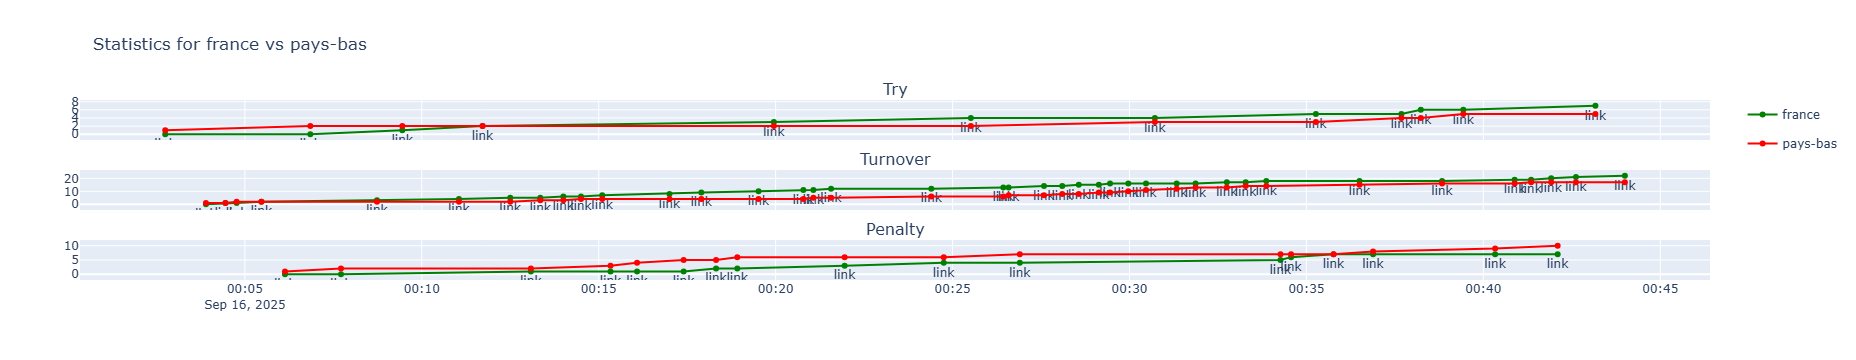

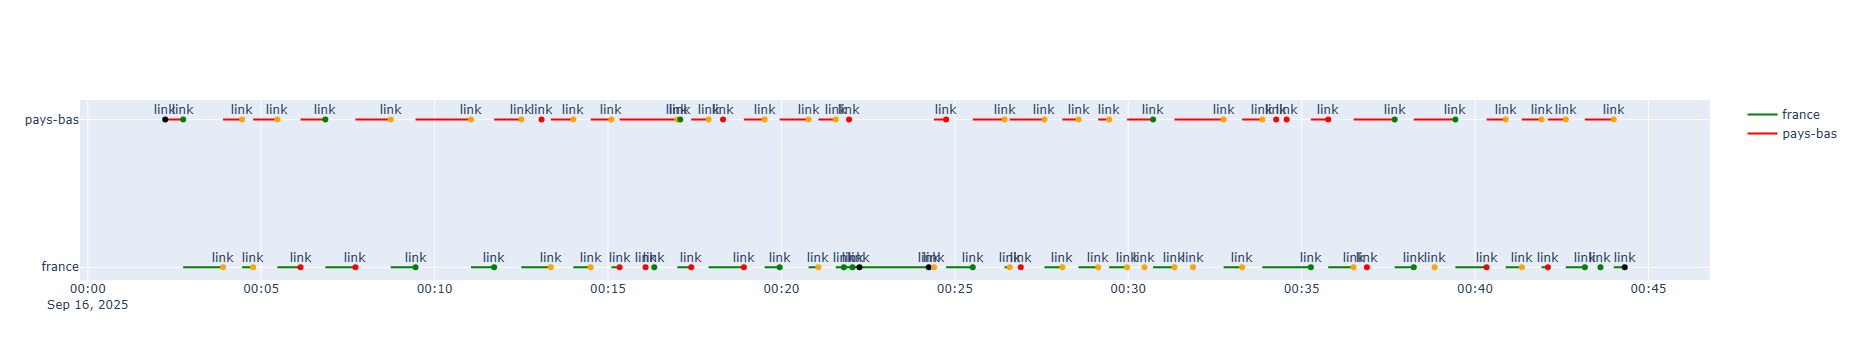

C:\Users\robin\AppData\Local\Temp\ipykernel_5076\3661553388.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\robin\AppData\Local\Temp\ipykernel_5076\3661553388.py:32: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

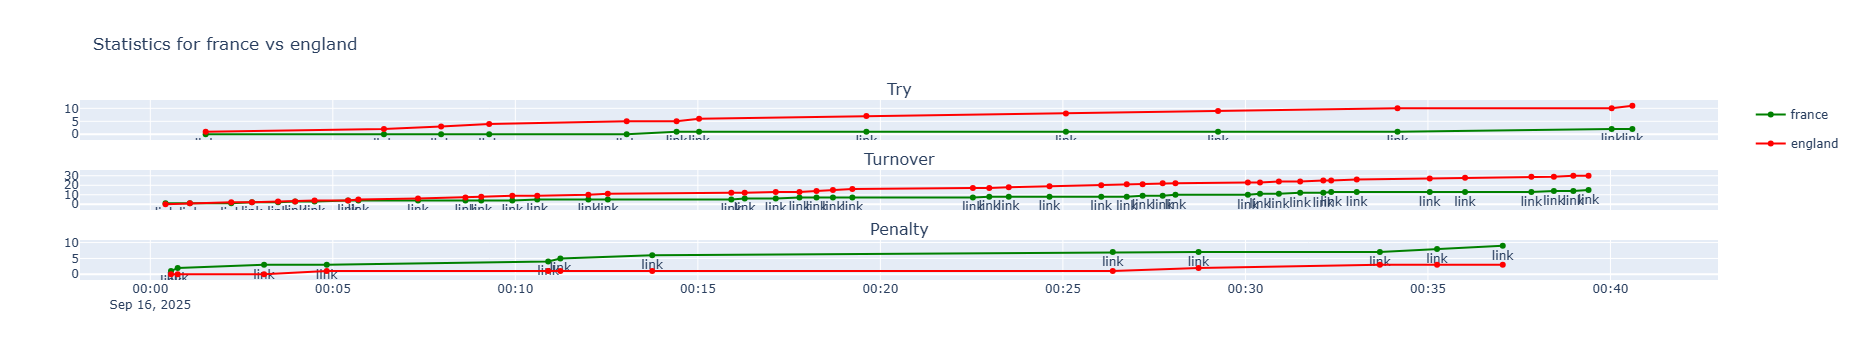

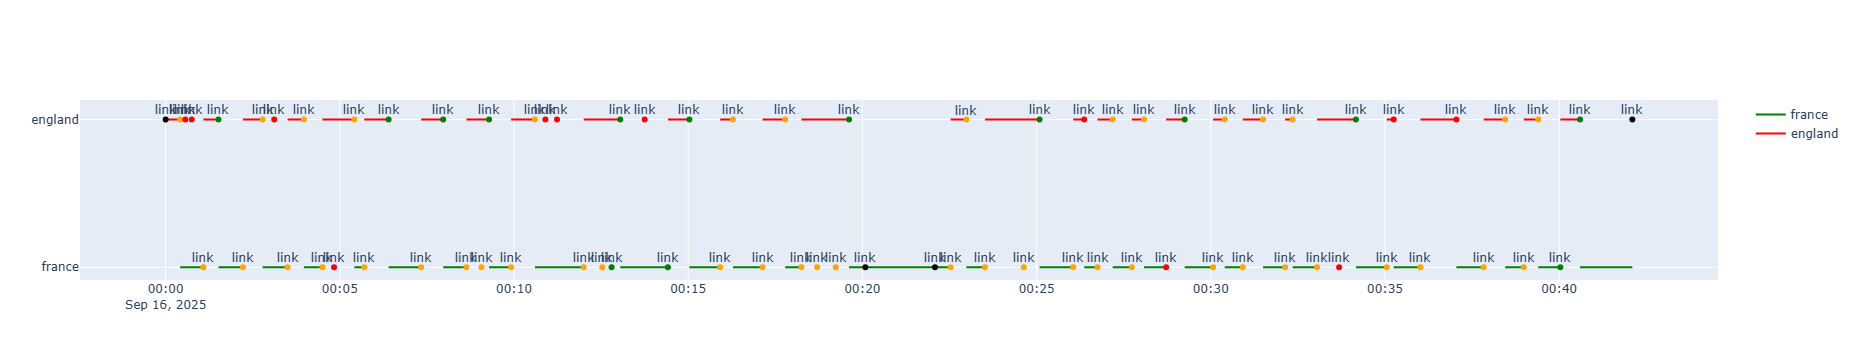

In [47]:
from jinja2 import Template


def get_names(data_path):
    name_1 = data_path.stem.split("_")[0]
    name_2 = data_path.stem.split("_")[1]
    return name_1, name_2


input_template_path = ASSETS_ROOT / "template.html"
for i, data_path in enumerate(
    [
        DATA_ROOT / "france_pays-bas.csv",
        DATA_ROOT / "france_england.csv",
    ]
):
    output_html_path = ROOT / f"game_{i}.html"
    local_team_name, other_team_name = get_names(data_path)
    data_df = load_data(data_path, local_team_name, other_team_name)

    new_stats_df = get_stats_df(data_df, local_team_name, other_team_name)
    trend_fig = make_fig_1(data_df, local_team_name, other_team_name)
    game_fig = make_game_fig(data_df, local_team_name, other_team_name)

    plotly_jinja_data = {
        "game_fig": game_fig.to_html(full_html=False),
        "trend_fig": trend_fig.to_html(full_html=False),
        "stats_table": new_stats_df.to_html(),
    }
    # consider also defining the include_plotlyjs parameter to point to an external Plotly.js as described above

    with output_html_path.open("w", encoding="utf-8") as output_file:
        with input_template_path.open() as template_file:
            j2_template = Template(template_file.read())
            output_file.write(j2_template.render(plotly_jinja_data))

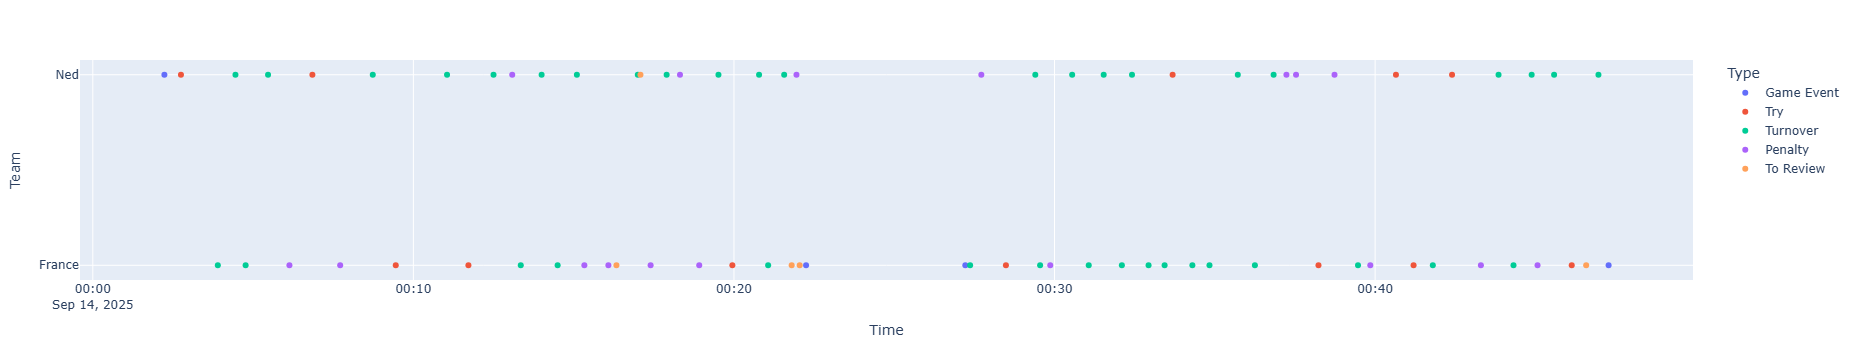

In [34]:
fig = px.scatter(
    data_df,
    x="Time",
    y="Team",
    hover_name="Name",
    hover_data="Comment",
    color="Type",
    category_orders={"Team": [OTHER_TEAM_NAME, "France"]},
)
fig.write_html(output_data_root / "recap.html")
fig.show()

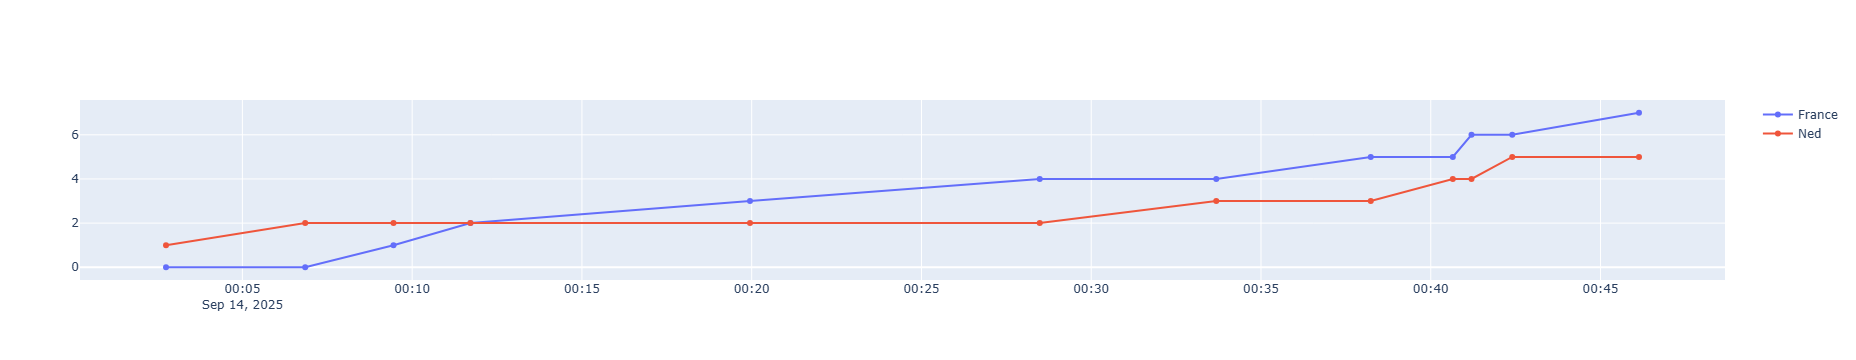

In [35]:
score_data = []
score_local = 0
score_other = 0
for i, row in data_df[data_df["Type"] == "Try"].iterrows():
    if row["Against France"]:
        score_other += 1
    else:
        score_local += 1
    score_data.append([row["Time"], score_local, score_other])
score_df = pd.DataFrame(
    score_data, columns=["Time", f"Score {LOCAL_TEAM_NAME}", f"Score {OTHER_TEAM_NAME}"]
)


fig = go.Figure()
fig.add_scatter(
    x=score_df["Time"],
    y=score_df[f"Score {LOCAL_TEAM_NAME}"],
    name=LOCAL_TEAM_NAME,
    mode="markers+lines",
)
fig.add_scatter(
    x=score_df["Time"],
    y=score_df[f"Score {OTHER_TEAM_NAME}"],
    name=OTHER_TEAM_NAME,
    mode="markers+lines",
)
fig.update_layout(hovermode="x unified")
fig.write_html(output_data_root / "score.html")
fig.show()

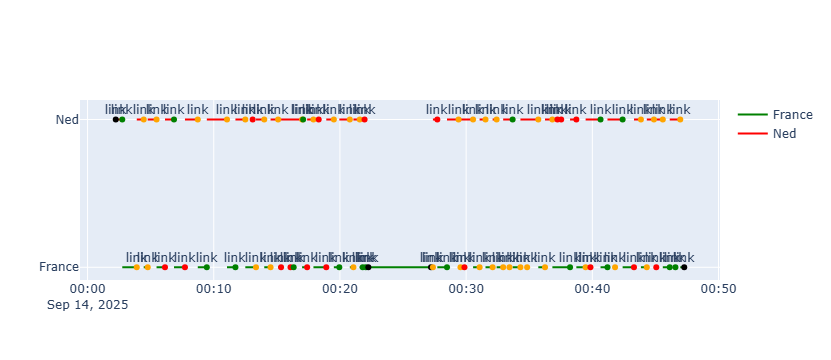